In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Because the dataset is pretty big, you can specify low_memory = False to make sure that you get the variable types correct on your rows
# The dataset has a additional column at the top that you can skip using the skiprows argument
raw_data = pd.read_csv("modeling_dataset.csv", low_memory = False)

In [3]:
columns_to_remain= ['broke_up','living_together','currently_married','time_since_cohab','marital_status','time_since_first_relationship','time_since_romantic','HOW_LONG_AGO_FIRST_MET_CAT','time_since_met','lived_together_before_married','time_met_until_married','age_married','time_dating_until_married','age','members_gt_18','no_domestic_partnership_or_civil_union','has_domestic_partnership','has_civil_union']

processed_data = raw_data[columns_to_remain]
print(processed_data.columns.values)

['broke_up' 'living_together' 'currently_married' 'time_since_cohab'
 'marital_status' 'time_since_first_relationship' 'time_since_romantic'
 'HOW_LONG_AGO_FIRST_MET_CAT' 'time_since_met'
 'lived_together_before_married' 'time_met_until_married' 'age_married'
 'time_dating_until_married' 'age' 'members_gt_18'
 'no_domestic_partnership_or_civil_union' 'has_domestic_partnership'
 'has_civil_union']


In [31]:
# Data cleaning 
# no_domestic_partnership_or_civil_union, has_domestic_partnership 
# and has_civil_union columns have many missing values.
# So, I try to revise missing values to "refused"

processed_data['no_domestic_partnership_or_civil_union'].fillna('refused')
processed_data['has_domestic_partnership'].fillna('refused')
processed_data['has_civil_union'].fillna('refused')


0            no
1            no
2            no
3            no
4            no
5            no
6       refused
7       refused
8            no
9            no
10      refused
11           no
12           no
13           no
14          yes
15          yes
16           no
17           no
18           no
19           no
20      refused
21      refused
22           no
23           no
24           no
25           no
26           no
27           no
28      refused
29      refused
         ...   
3115    refused
3116    refused
3117    refused
3118    refused
3119    refused
3120    refused
3121    refused
3122    refused
3123    refused
3124    refused
3125    refused
3126    refused
3127    refused
3128    refused
3129    refused
3130    refused
3131    refused
3132    refused
3133    refused
3134    refused
3135    refused
3136    refused
3137    refused
3138    refused
3139    refused
3140    refused
3141    refused
3142    refused
3143    refused
3144    refused
Name: has_civil_union, d

In [4]:
# Imputation and create holdout
from sklearn import preprocessing

categorical = processed_data.select_dtypes(include=['object'])
numeric = processed_data.select_dtypes(exclude=['object'])

for name, values in categorical.items():
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
    
for name in numeric:
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
        
y = numeric['broke_up']
X = numeric.drop(['broke_up'], axis = 1)

# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [33]:
# Logistic Regression
# choose the model
from sklearn import linear_model
lr = linear_model.SGDClassifier(loss='log', penalty='l2', n_jobs = -1)

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', lr) ])

# tune the model
my_ratio = np.linspace(0.1,1, num = 10)
my_alpha = np.logspace(0.001, 1, num = 10)
number_of_iter = [100,150,200]

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__alpha = my_alpha
                                              , model__l1_ratio = my_ratio
                                              , model__n_iter = number_of_iter)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)
print(optimized_lr.best_estimator_)
print("Best score of SGDClassifier = %f" %(optimized_lr.best_score_))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   53.4s finished


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=2.7861211686297702, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.40000000000000002, learning_rate='optimal', loss='log',
       n_iter=200, n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, verbose=0, warm_start=False))])
Best score of Linear Regression = 0.832693


In [34]:
# Decision Tree
# choose the model
from sklearn import tree
my_tree = tree.DecisionTreeClassifier()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()), ('model', my_tree) ])

# tune the model
depth_value = [4,5,6,7,8,9,10,12,13,14,15]

from sklearn.model_selection import GridSearchCV
optimized_tree = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__max_depth = depth_value)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_tree.fit(X_train, y_train)
print(optimized_tree.best_estimator_)
print("Best score of DecisionTree = %f" %(optimized_tree.best_score_))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  40 out of  55 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.8s finished


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
Best score of DecisionTree = 0.745400


In [5]:
# Random Forest
# choose the model
from sklearn import ensemble
forest = ensemble.RandomForestClassifier()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()), ('my_model', forest) ])

# tune the model
estimators = [10,20,30]
depth_value = [3,4,5,6,7]
number_of_features = [20,30,40,50]

from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(my_model__n_estimators = estimators
                                             , my_model__max_depth = depth_value
                                             , my_model__max_features = number_of_features)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
print(optimized_rf.best_estimator_)
print("Best score of RandomForest = %f" %(optimized_rf.best_score_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('my_model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=30, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
Best score of RandomForest = 0.839736


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished


In [36]:
# Gradient Boosting
# choose the model
from sklearn import ensemble

gradient_boosting = ensemble.GradientBoostingClassifier()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()), ('my_model', gradient_boosting) ])

# tune the model
estimators = [10,20,30]
depth_value = [3,4,5,6,7]
number_of_features = [20,30,40,50]
number_of_learning_rate = [0.1,0.3,0.5]

from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(my_model__n_estimators = estimators
                                             , my_model__max_depth = depth_value
                                             , my_model__max_features = number_of_features
                                             , my_model__learning_rate = number_of_learning_rate)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train, y_train)
print(optimized_gb.best_estimator_)
print("Best score of Gradient Boosting = %f" %(optimized_gb.best_score_))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   25.9s


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('my_model', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=40, max_leaf_nodes=None,
              min_impurity...s=30, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])
Best score of Gradient Boosting = 0.838674


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   27.9s finished


In [50]:
optimized_rf.predict(X_test)
print("Accuracy of test set (Random Forest) = %f" %optimized_rf.score(X_test, y_test))

Accuracy of test set (Random Forest) = 0.998130


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.7s finished


Confusion matrix, without normalization
[[591   0]
 [ 38   0]]


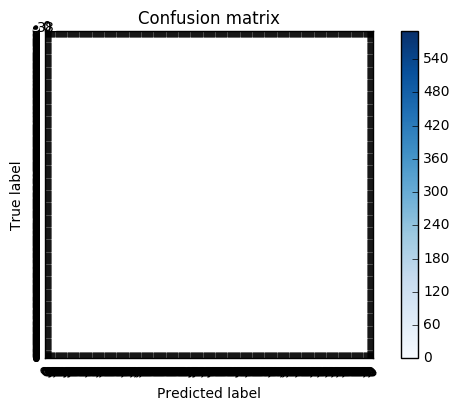

In [6]:
# Choose randomforest model and apply for test set

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = optimized_rf.fit(X_test, y_test).predict(X_test)
class_names = y_test


# get confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()